## qDESS T2 mapping
###### Author: Zimu Huo
###### Date: 03.2022


The code is **translated and modified** from Akshay Chaudhari's code which is originally in Matlab scripts

Special thanks to Pete and Neal for sending me the resources 

-------------------------------------------------------------------------
References
    
    [1] 
    Author: B Sveinsson et al. 
    Title: A Simple Analytic Method for Estimating T2 in the Knee from DESS
    Link: https://www.ncbi.nlm.nih.gov/pubmed/28017730
    

         

In [1]:
import os 
from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path
import pydicom as dcm
import math
from numpy import sqrt, sin, cos, pi, exp, log
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
def T2_qDESS(filePath, spl_dur, GlArea, tissue, **kwargs):
    
    '''
    -------------------------------------------------------------------------
    Parameters
    
    filePath: string  
    filepath of the dicom images used for T2 mapping
    
    spl_dur: s 
    Flip or tip angle of the magnetization vector 
    
    spl_area: mT/(ms) 
    Area of the spoiler gradient in units (G/cm)*us
    
    tissue: string 
    Type of tissue, like bones, CSF, fat.
    
    Optional parameters: 
    
    T1: s
    estimated T1 value of the tissue
    
    D: m^2/s
    estimate for the diffusivity of the tissue
    
    -------------------------------------------------------------------------
    Returns
    images : array like
    images of the dicom files under the given dir
    
    t2map : array like 
    t2 map
    
    -------------------------------------------------------------------------
    Notes
    
    user can estimate T1 and diffusivity of the tissue for better results or the function can accept more images for better mapping
    
    -------------------------------------------------------------------------
    References
    
    [1] 
    Author: B Sveinsson et al. 
    Title: A Simple Analytic Method for Estimating T2 in the Knee from DESS
    Link: https://www.ncbi.nlm.nih.gov/pubmed/28017730
    
    '''
    
    
    data = Path(filePath)
    dirs = list(data.glob('**/*.IMA'))
    dirs = np.sort(dirs)
    
    file0 = dcm.read_file(dirs[0]) 
    f = file0.pixel_array
    [height, width] = f.shape
    N = len(dirs)

    #could store matter infor in a table to check otherwise read the estimator from user 
    tissue = kwargs.get('tissue', 'sciatic nerve')
    #if sciatic nerver.... use dict, objects etc. 
    
    T1 = kwargs.get('T1', 1.2)
    D = kwargs.get('D', 1.25e-9)
    TR = file0.RepetitionTime*1e-3
    TE = file0.EchoTime*1e-3
    alpha = file0.FlipAngle
    Gl = GlArea/(spl_dur*1e6)*100
    gamma = 4258*2*np.pi
    dkL = gamma*Gl*spl_dur
    k = ((math.sin(math.radians(alpha/2))))**2*((1 + exp(-TR/T1 - TR*dkL**2*D)))/(1 - (math.cos(math.radians(alpha)))*exp(-TR/T1 - TR*dkL**2*D))
    c1 = (TR-spl_dur/3)*dkL**2*D
    del file0
    del f
    images = np.zeros([height,width,N])
    for index,f in enumerate (dirs):
        image = dcm.read_file(f).pixel_array
        images[:,:,index] = image
    dess = np.zeros([height,width,int(N/2),2])
    dess[:,:,:,0] = images[:,:,0:int(N/2)]
    dess[:,:,:,1] = images[:,:,int(N/2):]
    mask = np.ones([height,width,int(N/2)])
    ratio = np.zeros([height, width, int(N/2)])
    ratio = mask*dess[:,:,:,1]/dess[:,:,:,0];
    t2map = (-2000*(TR-TE)/(log(abs(ratio)/k)+c1))
    return t2map, images

In [3]:
filePath = "src/spoil30"
GlArea = 30*1e2
spl_dur = 4.8e-3
t2map, images = T2_qDESS(filePath, spl_dur, GlArea, "sciatic nerve")
t2map[t2map <=0] = np.NaN;
t2map[t2map > 100] = np.NaN;

/var/folders/5d/6p36mvb505x5j7b_90jtxdsr0000gn/T/ipykernel_97309/3659221372.py:85: RuntimeWarning: invalid value encountered in true_divide
  ratio = mask*dess[:,:,:,1]/dess[:,:,:,0];


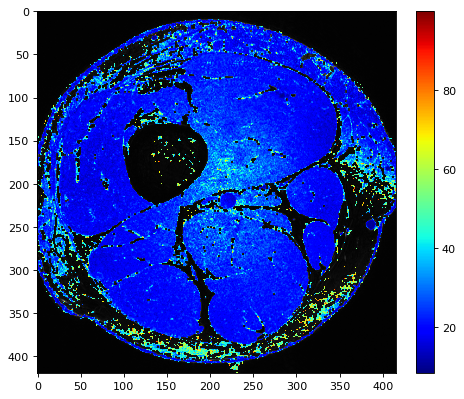

In [4]:
i = 80
plt.figure(figsize=(8, 6), dpi=80)
plt.imshow(images[:,:,i],cmap = 'gray')
tf = plt.imshow(t2map[:,:,i], cmap ='jet')
plt.colorbar(tf, fraction=0.046, pad=0.04)
plt.title("T2")
plt.show()

In [5]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

plt.figure(figsize=(12, 8), dpi=80)
def show(slice):
   
    slice = int(slice)
    plt.imshow(images[:,:,slice],cmap = 'gray')
    tf = plt.imshow(t2map[:,:,slice], cmap ='jet')
    plt.colorbar(tf, fraction=0.046, pad=0.04)

interact(show, slice = widgets.FloatSlider(value=80,
                                               min=0,
                                               max=119,
                                               step=1))

<Figure size 960x640 with 0 Axes>

interactive(children=(FloatSlider(value=80.0, description='slice', max=119.0, step=1.0), Output()), _dom_class…

<function __main__.show(slice)>

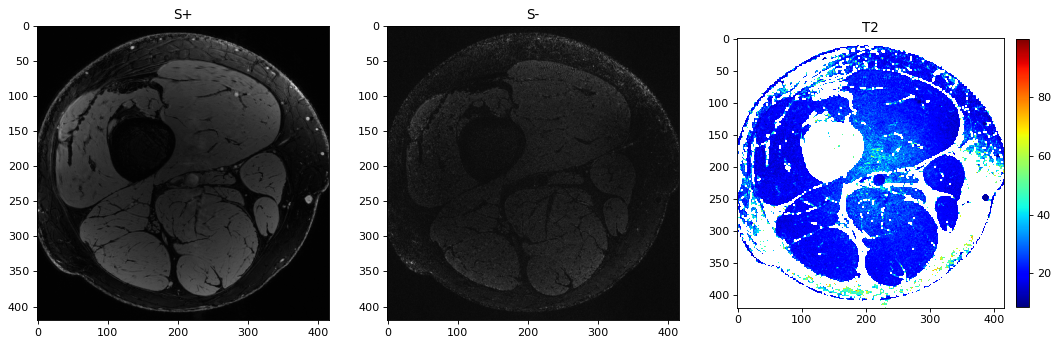

In [6]:
i = 80
plt.figure(figsize=(16, 12), dpi=80)
plt.subplot(131)
plt.imshow(images[:,:,i],cmap = 'gray')
plt.title("S+")
plt.subplot(132)
plt.imshow(images[:,:,i+119],cmap = 'gray')
plt.title("S-")
plt.subplot(133)
tf = plt.imshow(t2map[:,:,i], cmap ='jet')
plt.colorbar(tf, fraction=0.046, pad=0.04)
plt.title("T2")
plt.show()